In [1]:
# Required Libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK Resources
import nltk



In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

# Set up Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
# Expanded list of stopwords including bigrams
SINGLE_STOPWORDS = set(stopwords.words('english')).union({
    # General fillers
    'get', 'got', 'like', 'know', 'one', 'thing', 'things', 'really', 'would', 'could', 'also',
    'even', 'make', 'much', 'many', 'say', 'said', 'well', 'still', 'dont', 'didnt', 'cant', 'im',
    'us', 'use', 'using', 'way', 'need', 'want', 'think', 'go', 'going', 'take', 'give', 'see', 'may',
    
    # Contextless personal pronouns
    'i', 'you', 'he', 'she', 'we', 'they', 'me', 'him', 'her', 'them', 'your', 'my', 'our', 'their',
    
    # Domain-generic words
    'agency', 'federal', 'employee', 'employees', 'government', 'position', 'job', 'jobs', 'office',
    'manager', 'supervisor', 'human', 'resource', 'work', 'working', 'time', 'day', 'year', 'month',
    'week', 'leave', 'pay', 'email', 'contact', 'title', 'context', 'question', 'concern', 'thank',
    'please', 'subreddit', 'moderator', 'bot', 'automatically', 'performed', 'message', 'compose',

    # Reddit/meta-specific terms
    'removed', 'deleted', 'post', 'thread', 'comment', 'reply', 'upvote', 'downvote',

})


BIGRAM_STOPWORDS={

    # Contractions (as bigrams often yield them)
    'you re', 'they re', 'we re', 'it s', 'that s', 'what s', 'who s', 'isn t', 'wasn t', 'aren t',
    'doesn t', 'don t', 'didn t', 'hasn t', 'haven t', 'hadn t', 'can t', 'couldn t', 'shouldn t',

    # Low-value system phrases from earlier outputs
    'provide context', 'context title', 'please contact', 'bot action', 'message compose',
    'fednews question', 'action performed', 'performed automatically', 'compose fednews',
    'moderator subreddit', 'subreddit message', 'contact moderator', 'question concern',
    'automatically please',
}




[nltk_data] Downloading package stopwords to
[nltk_data]     /home/csgrads/shahr072/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/csgrads/shahr072/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def clean_text(text):
    """
    Function to clean and preprocess the text.
    - Converts to lowercase.
    - Removes URLs and punctuation.
    - Lemmatizes first, then removes single word stopwords and bigram stopwords.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+", "", text)

    # Remove punctuation
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)

    # Tokenize the text
    tokens = text.split()

    # First, lemmatize all tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Remove single-word stopwords
    filtered_tokens = [token for token in lemmatized_tokens if token not in SINGLE_STOPWORDS and len(token) > 2]

    # Now remove bigrams
    i = 0
    final_filtered_tokens = []
    while i < len(filtered_tokens):
        # Create bigram
        if i < len(filtered_tokens) - 1:
            bigram = f"{filtered_tokens[i]} {filtered_tokens[i+1]}"
            # Skip if it's in the bigram stopwords list
            if bigram in BIGRAM_STOPWORDS:
                i += 2  # Skip both words of the bigram
                continue

        # Add lemmatized token to final list
        final_filtered_tokens.append(filtered_tokens[i])
        i += 1  # Move to the next token

    return " ".join(final_filtered_tokens)

In [6]:
from datetime import datetime  # Add this line to import datetime

# Load the posts and comments from JSONL files
def load_jsonl(file_path, text_fields):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    rows = []
    for item in data:
        if any(item.get(field, '') in ['[removed]', '[deleted]'] for field in text_fields):
            continue
        text = ' '.join(item.get(field, '') for field in text_fields)
        timestamp = item.get('created_utc')
        if text and timestamp:
            dt = datetime.utcfromtimestamp(timestamp)
            week = dt.strftime('%Y-%U')  # Convert to week format (year-week)
            rows.append((week, clean_text(text)))
    return rows


In [7]:
# Example: Load data for posts and comments

#posts = load_jsonl('../2_months_data/filtered_comments.jsonl', ['title', 'selftext'])
comments = load_jsonl('../2_months_data/filtered_comments.jsonl', ['body'])

/tmp/ipykernel_692712/3243174933.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(timestamp)


In [10]:
# Prepare documents for TF-IDF Vectorization (Combine posts and comments)
combined_by_week = defaultdict(list)
for week, text in comments:
    combined_by_week[week].append(text)

# Use TF-IDF Vectorizer to extract bigrams
def extract_topics(weekly_texts, ngram_range=(3, 3), min_df=2, max_df=0.6):
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    topic_ranks = {}
    for week, docs in weekly_texts.items():
        tfidf_matrix = vectorizer.fit_transform(docs)
        feature_names = vectorizer.get_feature_names_out()
        scores = tfidf_matrix.mean(axis=0).A1  # Average TF-IDF scores across documents
        top_indices = scores.argsort()[::-1][:20]  # Get top 30 bigrams
        top_terms = [feature_names[i] for i in top_indices]
        topic_ranks[week] = top_terms
    return topic_ranks

# Extract top topics per week
weekly_topics = extract_topics(combined_by_week, ngram_range=(3, 3), min_df=2, max_df=0.6)


In [11]:
# Invert the structure: topic -> {week -> rank}
topic_rank_by_week = defaultdict(dict)

for week, topics in weekly_topics.items():
    for rank, (topic) in enumerate(topics, start=1):
        topic_rank_by_week[topic][week] = rank

# Create DataFrame to store the ranks across weeks
all_weeks = sorted(weekly_topics.keys())
rank_df = pd.DataFrame(index=topic_rank_by_week.keys(), columns=all_weeks)

for topic, week_ranks in topic_rank_by_week.items():
    for week, rank in week_ranks.items():
        rank_df.at[topic, week] = rank

# Convert to numeric, handle missing data
rank_df = rank_df.apply(pd.to_numeric, errors='coerce')


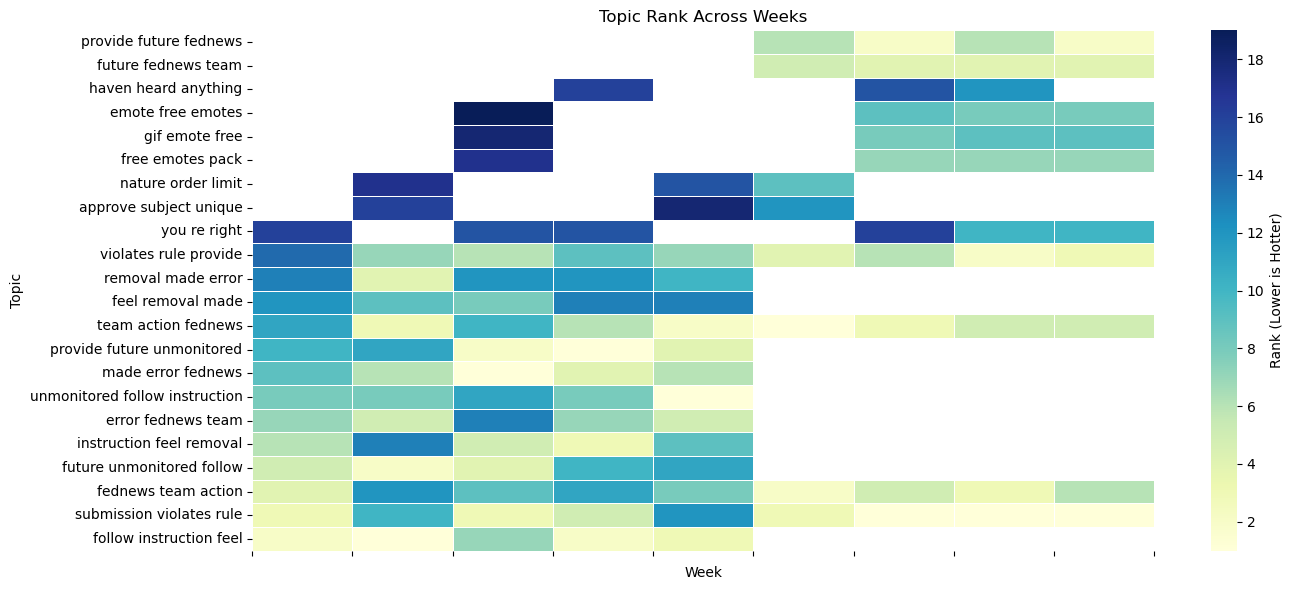

In [12]:
# Filter topics that appeared in at least 3 weeks
filtered_rank_df = rank_df.dropna(thresh=3)

# Visualize using a heatmap
plt.figure(figsize=(14, max(6, 0.25 * len(filtered_rank_df))))
sns.heatmap(filtered_rank_df, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Rank (Lower is Hotter)'}, linewidths=0.5)
plt.title("Topic Rank Across Weeks")
plt.xlabel("Week")
plt.ylabel("Topic")
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()
